In [1]:
import pandas as pd
import pickle
import numpy as np

In [14]:
pair_time = pd.read_csv('data/pairs_dense.csv',names=['user1','game1','user2','game2','time'])
pair_time['time'] = pd.to_datetime(pair_time['time'],unit='s')

In [20]:
pair_time.loc[pair_time['time']<'1970-01-01']

,user1,game1,user2,game2,time
588,13866,590,3357,461,1969-12-31 23:59:59
730,9752,1785,604,1183,1969-12-31 23:59:59


In [21]:
pair_time[pair_time['time']>='2000-01-01'].time.describe(datetime_is_numeric=True)

count                             2096
mean     2014-04-28 05:21:50.124045824
min                2013-10-01 19:51:32
25%                2013-11-05 03:47:58
50%                2014-01-27 19:25:24
75%                2014-09-14 02:22:07
max                2015-09-22 22:06:52
Name: time, dtype: object

In [2]:
# Load the gameswap transaction data with col names ['user1','game1','user2','game2']
pair = pd.read_csv('data/pairs.csv', names=['user1','game1','user2','game2'])
# Load have and wish data
have = pd.read_csv('data/have.csv', names=['user','game'])
wish = pd.read_csv('data/wish_dense.csv', names=['user','game'])

# Load the games data we get from IGDB
games = pd.read_csv('data/games_tbp.csv', index_col=0)
# Add a column of index with name 'game_id', second column
games.insert(1, 'game_id', range(0, len(games)))

games_genres = games[['game_id', 'genres']]

# Join the pair and games_genres on game1
pair_genres = pair.join(games_genres.set_index('game_id'), on='game1')
# Join the pair_genres and games_genres on game2
pair_genres = pair_genres.join(games_genres.set_index('game_id'), on='game2', rsuffix='_2')

relationship = pair_genres[['genres', 'genres_2']]
# Drop the rows with NaN
relationship = relationship.dropna()
# Transform the columns to list
relationship['genres'] = relationship['genres'].apply(lambda x: [int(y) for y in x[1:-1].split(',')])
relationship['genres_2'] = relationship['genres_2'].apply(lambda x: [int(y) for y in x[1:-1].split(',')])


relationship_explode = relationship.explode(['genres'])
relationship_explode = relationship_explode.explode(['genres_2'])
relationship_explode = relationship_explode.groupby(['genres', 'genres_2']).size().reset_index(name='count')

# If genres_2 is greater than genres, swap them
relationship_explode['genres'], relationship_explode['genres_2'] = \
    zip(*relationship_explode.apply(lambda x: (x['genres_2'], x['genres']) if x['genres_2'] > x['genres'] else (x['genres'], x['genres_2']), axis=1))

# Sort the values by genres and genres_2
relationship_explode = relationship_explode.sort_values(by=['genres', 'genres_2'])

# Group by genres and genres_2 and sum the count
relationship_explode = relationship_explode.groupby(['genres', 'genres_2']).sum().reset_index()

### Load the Information of Games
The detailed information about the games is got using IGDB.


In [3]:
with open('data/genres_igdb.pickle','rb') as f:
    genres_names = pickle.load(f)[['id','name']]

df = pd.merge(relationship_explode, genres_names, left_on='genres',right_on='id')
relationship_genres = pd.merge(df, genres_names, left_on='genres_2',right_on='id',suffixes=['_1','_2'])[['name_1','name_2','count']]
relationship_syn = relationship_genres.pivot('name_1','name_2','count')
# Make the relationship symmetric without changing the diagonal
relationship_syn = relationship_syn.fillna(0) + relationship_syn.T.fillna(0)
# Divide the diagonal by 2
np.fill_diagonal(relationship_syn.values, relationship_syn.values.diagonal()/2)
# Delete the rows and columns with all NaN
relationship_syn = relationship_syn.dropna(axis=0, how='all')
relationship_syn = relationship_syn.dropna(axis=1, how='all')

/tmp/ipykernel_6865/844700891.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


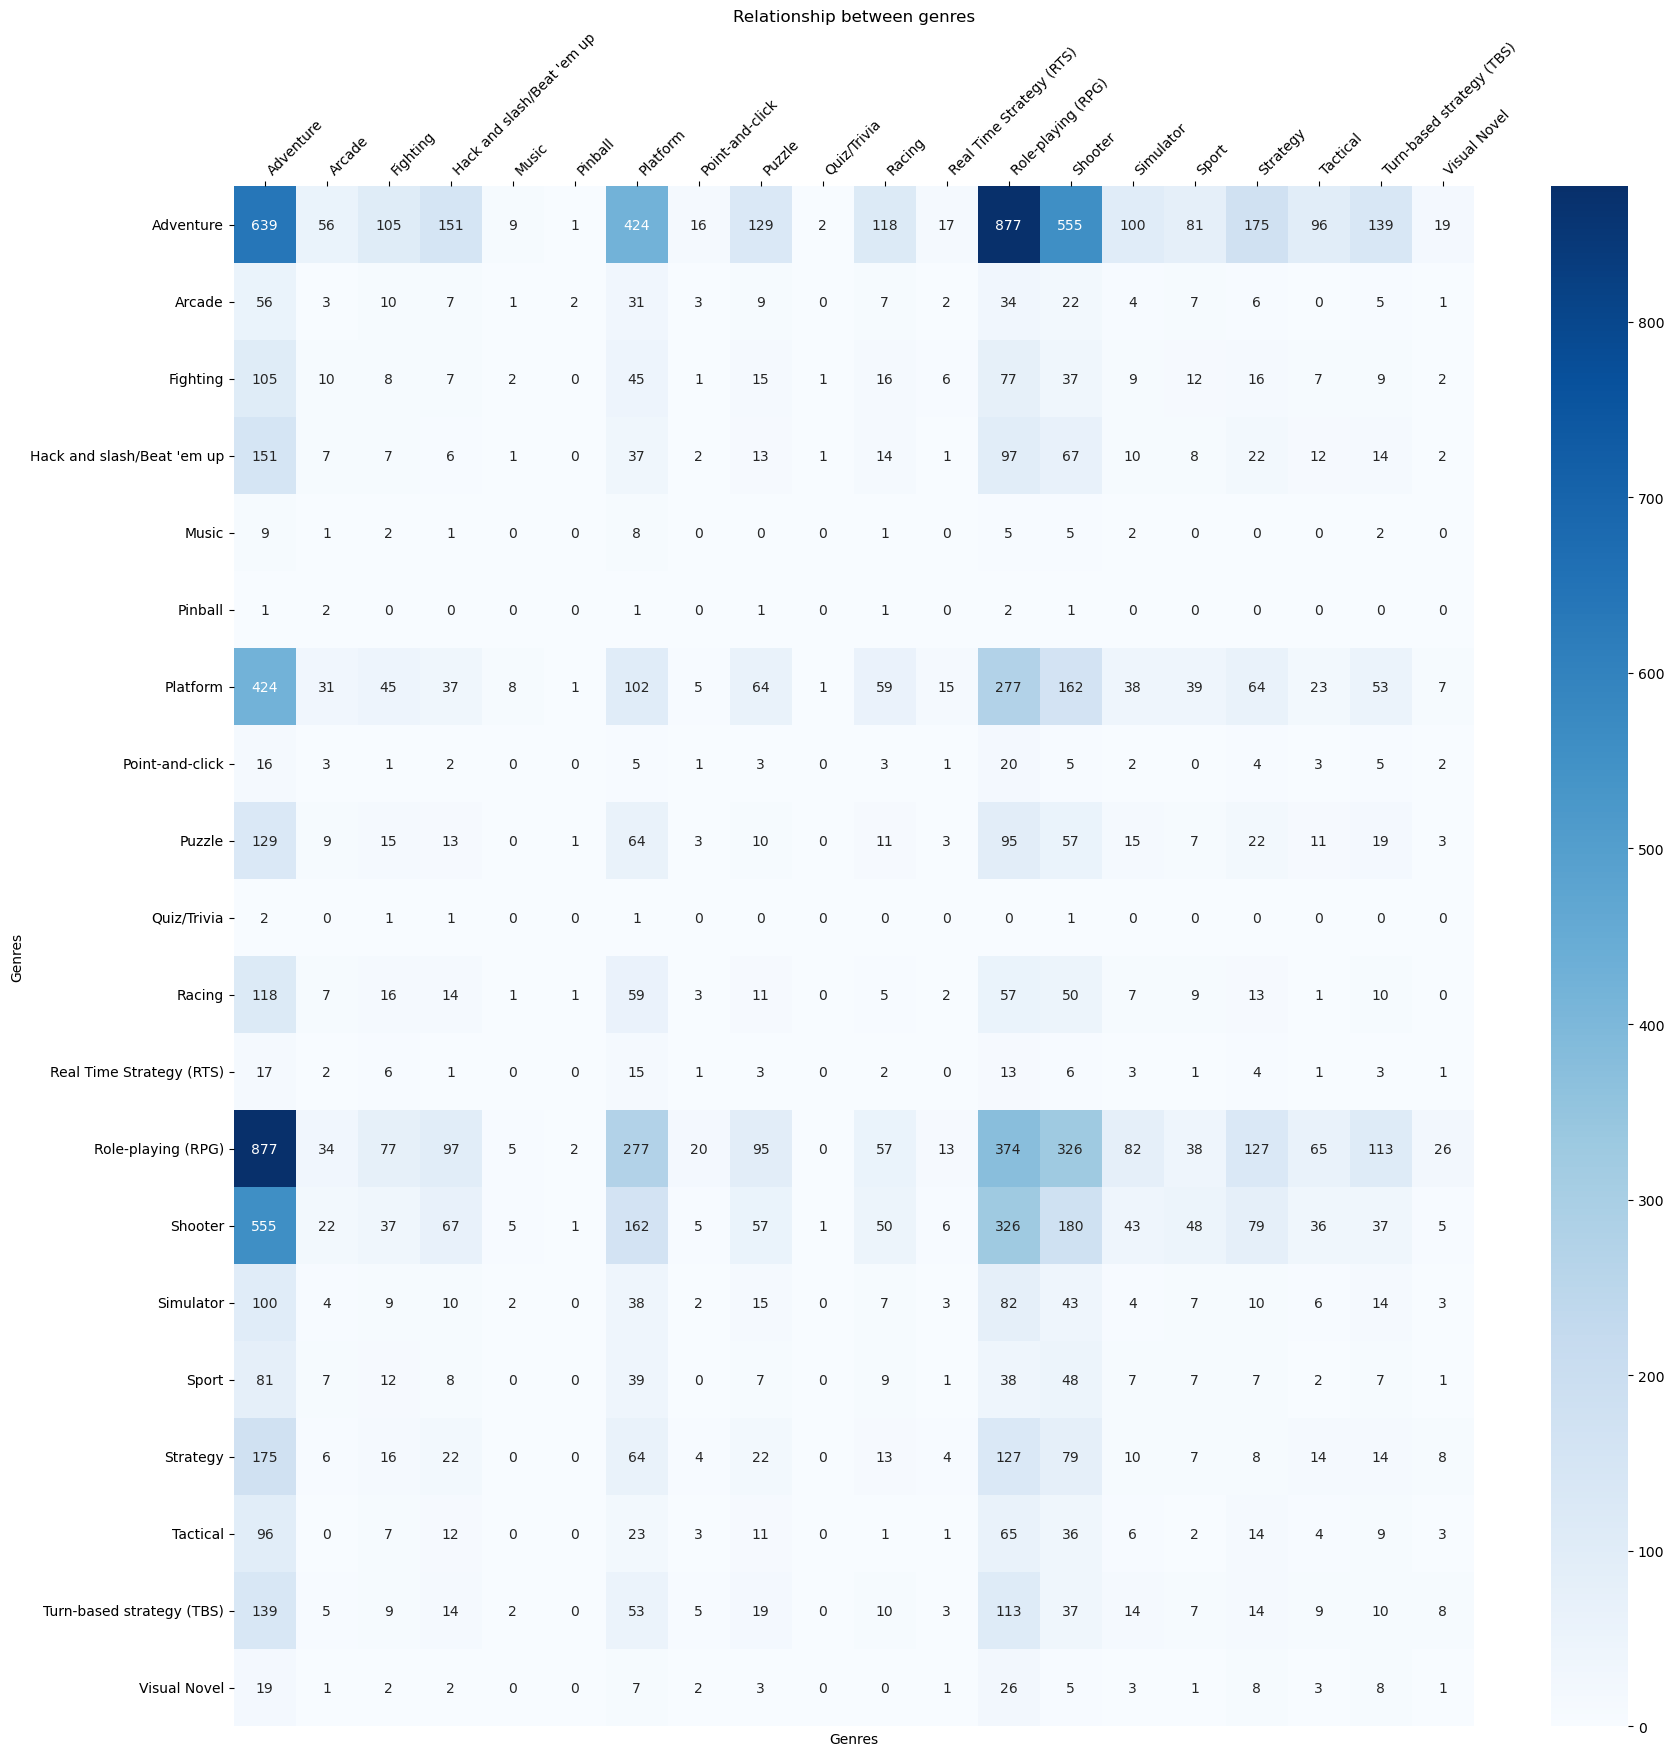

In [4]:
# Plot the relationship between genres
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Set the figure size
plt.figure(figsize=(20,20))
# Plot the relationship_genres symmetrically
# Annotate the heatmap with the count, not scientific notation
ax = sns.heatmap(relationship_syn, annot=True, fmt='g', cmap='Blues')
# Set the title
plt.title('Relationship between genres')
# Set the x-axis label
plt.xlabel('Genres')
# Let the x-axis in the upper side
ax.xaxis.tick_top()
# Rotate the x-axis label
plt.xticks(rotation=45, ha='left')
# Set the y-axis label
plt.ylabel('Genres')
plt.yticks(rotation=0)
# Save the figure
plt.savefig('plot/relationship.png',dpi=300)
plt.show()